> "Everything should be made as simple as possible, but not simpler." —Albert Einstein

In this lesson, you'll focus on the problem of *overfitting*. You'll also learn about *regularization*, which is a key approach to solving overfitting. After that, you'll explore *lasso*, *ridge*, and *elastic net* regressions, which are three variants of linear regression that incorporate regularization in their loss functions.

You'll learn about the following concepts:

- Overfitting
- Underfitting
- Generalization
- Regularization
- Ridge regression
- Lasso regression
- Elastic net regression

## Overfitting

One of the main challenges in machine learning is designing models that perform well not just on a training set, but also on a test set—or, more generally, on unseen observations. More concretely, you want the following: 

* Models that have a low error rate on the training set
* A low difference between the errors in the test set and in the training set

A model's ability to achieve that second requirement is called *generalization*, and the difference between the errors in the test and training sets is called the *generalization gap*. A good model should generalize well, and its generalization gap should be as small as possible.

Overfitting and underfitting are foundational concepts in machine learning, and understanding them is crucial for designing good models. If the generalization gap of a model is larger than you want, that's called *overfitting*. And if the training performance of a model is low, that's called *underfitting*.

Earlier in this module, when you were learning about the goodness of fit, you were actually trying to come up with models that didn't underfit. But avoiding underfitting is only one side of selecting a good model. The second part is related to prediction, and this is where the discussion of overfitting comes in.

To understand overfitting better, you'll explore it with an example. Below, you'll generate a quadratic relationship between two variables. Then, you'll estimate the relationship with three different linear regression models: one using a linear, one using a quadratic, and one with a tenth order polynomial of the feature.

In [1]:
# These are the libraries that you'll use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(456)

# `X` is the feature
X = pd.DataFrame(25 - np.arange(1,51)) 

# Define `Y` as a quadratic function of `X`
# Add a little bit of noise to `Y`
Y = X + X**2 +  pd.DataFrame(np.random.normal(0,100,50))

# This is the model with a linear feature
lrm_underfit = LinearRegression().fit(X, Y)
preds_underfit = lrm_underfit.predict(X)

# This is the model with a quadratic feature
X_correct = pd.concat([X, X**2], axis=1)
lrm_correct = LinearRegression().fit(X_correct, Y)
preds_correct = lrm_correct.predict(X_correct)

# This is the model with up to a tenth order polynomial of the feature
X_overfit = pd.concat([X**i for i in range(1,11)], axis=1)
lrm_overfit = LinearRegression().fit(X_overfit, Y)
preds_overfit = lrm_overfit.predict(X_overfit)

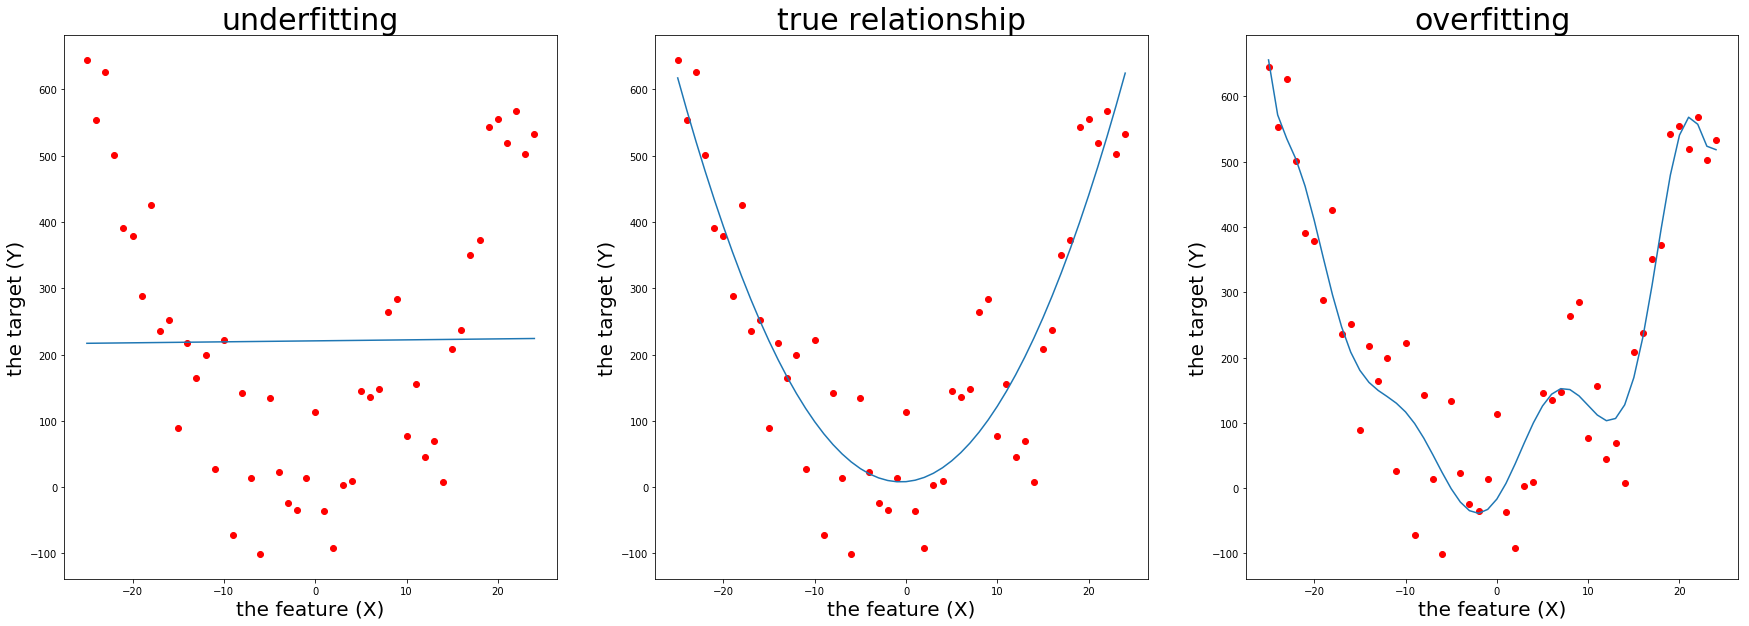

In [3]:
# Plot the predictions of the three models
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
plt.scatter(X, Y, color="red")
plt.plot(X, preds_underfit)
plt.title("underfitting", fontsize=30)
plt.xlabel("the feature (X)", fontsize=20)
plt.ylabel("the target (Y)", fontsize=20)

plt.subplot(1,3,2)
plt.scatter(X, Y, color="red")
plt.plot(X, preds_correct)
plt.title("true relationship", fontsize=30)
plt.xlabel("the feature (X)", fontsize=20)
plt.ylabel("the target (Y)", fontsize=20)

plt.subplot(1,3,3)
plt.scatter(X, Y, color="red")
plt.plot(X, preds_overfit)
plt.title("overfitting", fontsize=30)
plt.xlabel("the feature (X)", fontsize=20)
plt.ylabel("the target (Y)", fontsize=20)

plt.show()

The first chart demonstrates underfitting. The true relationship is quadratic—so by fitting a straight line, the model does a poor job explaining variation in the target.

The third chart illustrates overfitting. The tenth order polynomial fits the noise in the data. If you look at the rightmost part of the fitted <font color=blue>blue line</font> in the third graph, you can see that the line starts to turn down. But all of the target values for large values of the feature will continue to come toward the top-right corner of the graph. Hence, the model in the third chart will not correctly predict those values.

The second chart depicts the true relationship between the data. The fitted line is robust to noise and captures the correct relationship.

As a general rule, if your model is too complex, it will tend to overfit. Inversely, if your model is not complex enough, it will underfit the training set.

Keep in mind that a model's complexity is also referred to as its *capacity*. So if you find that your model is overfitting, you should reduce the complexity or capacity of the model. You can do this by eliminating some unimportant features from the model or by reducing the degree of the polynomial. In addition, there are also some general approaches to deal with overfitting. One of them is *regularization*, which you'll learn about later in this lesson.

Below, you'll use the *House prices* dataset and create an overly complex model to overfit the data. Specifically, you'll use all of the numerical features in the data and their powers up to `21`.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'


engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query(text('SELECT * FROM houseprices'), con=engine.connect())

# No need for an open connection, because you're only doing a single query
engine.dispose()

# `Y` is the target variable
Y = houseprices_df['saleprice']

numerical_cols = [col_name for col_name in houseprices_df.dtypes[houseprices_df.dtypes.values == 'int64'].index 
                    if col_name not in ["id", "saleprice"] ]

X = houseprices_df[numerical_cols]

X = pd.concat([X**i for i in range(1,21)], axis=1)

# `X` is the feature set

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# Fit an OLS model using scikit-learn
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# You are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

The number of observations in training set is 1168
The number of observations in test set is 292
R-squared of the model in the training set is: 0.9517853519509283
-----Test set statistics-----
R-squared of the model in the test set is: -9.47457138143506e+21
Mean absolute error of the prediction is: 827138492868694.8
Mean squared error of the prediction is: 6.360946853101283e+31
Root mean squared error of the prediction is: 7975554434082488.0
Mean absolute percentage error of the prediction is: 301974753740.1066


As you can see, the R-squared of the model in the training set is `0.95`, whereas the R-squared is negative in the test set. Because the difference between them is too large, your model overfits the training set. Above, you can also look at the prediction statistics on the test set. Later, you'll be able to compare these statistics with the models that you'll see in the remainder of this lesson.

## Regularization

To make a model more generalizable to a test set, you'll sometimes adjust the model's learning objectives or loss functions. By doing this, you actually impose your preferences over potential solutions. You force the model to choose one of your preferred solutions, assuming that there isn't a nonpreferred solution that performs significantly better. In general, the term *regularization* refers to the process of modifying algorithms in order to lower the generalization gap without sacrificing training performance.

When linear regression was introduced earlier in this module, it was mentioned that model fit is determined by minimizing the sum of the squared differences between the predicted and actual values. This is *ordinary least squares* (OLS):

$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2$$

It just so happens, however, that you can get more accurate predictions by modifying this *cost function*, a function that measures the performance of a machine-learning model for given data. A cost function quantifies the error between predicted values and expected values, and presents it in the form of a single real number. One way to think of this is that the OLS cost function optimizes the variance explained in the training set. *Ridge*, *lasso*, and *elastic net* regression are three examples of modifying this cost function. They each optimize the variance explained in the test sets. In general, your goal is to make a model that tells you about the world, not just your training sample—so ridge, lasso, and elastic net solutions are useful.


## Ridge regression

Ridge regression minimizes this cost function:

$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2+\lambda\sum_{j=1}^p\beta_j^2 $$

Comparing this cost function to the OLS cost function above, you can see that it consists of the OLS function with a new part to the right:

$$\lambda\sum_{j=1}^p\beta_j^2 $$

This new part imposes a penalty for large coefficients. It represents the sum of the square of all model coefficients (numbered $1$ through $p$), multiplied by the regularization parameter $\lambda$ (lambda). As $\lambda$ increases, the coefficient size penalty also increases. And the solution that minimizes the cost function will, by necessity, have smaller coefficient estimates. Regularization based on the sum of the squared weights is also called *L2 regularization*.

###### The convention is to call the regularization parameter *lambda* ($\lambda$), but scikit-learn calls this parameter *alpha* instead. This is because *lambda* is a reserved keyword in Python.

The core principle behind ridge regression is that as model complexity increases and features correlate with one another more and more (become _multicollinear_), coefficients arrived at by OLS become increasingly large. This is a sign that the model is incorporating too much variance from the training set—in other words, it is overfitting. Ridge regression is a model variance minimizer; it works to keep this from happening.
If you're interested in a deep dive into the underlying math and origin of the term *ridge regression*, see this detailed [Stack Exchange answer](http://stats.stackexchange.com/questions/151304/why-is-ridge-regression-called-ridge-why-is-it-needed-and-what-happens-when).

Now, build a ridge regression model on the *House prices* dataset to deal with the previous model's overfitting. You'll use the same features as the linear regression model above.

In [5]:
from sklearn.linear_model import Ridge

# Fitting a ridge regression model. Here, `alpha` is the regularization
# parameter (usually called `lambda`). As `alpha` gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=10**37) 
ridgeregr.fit(X_train, y_train)

# You are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.6771899948741743
-----Test set statistics-----
R-squared of the model on the test set is: 0.29355807962919017
Mean absolute error of the prediction is: 48573.03718450391
Mean squared error of the prediction is: 4742842002.421966
Root mean squared error of the prediction is: 68868.29460950784
Mean absolute percentage error of the prediction is: 28.88179458959394


The R-squared of the training set dropped from `0.95` to `0.67`. Although this seems like a deterioration, if you look at the R-squared in the test set, you can see that it's now `0.30`—which marks a significant jump from negative. Moreover, all of the performance statistics from the test set improved quite substantially. This means that by using ridge regression, you reduced overfitting.

### Tuning ridge's regularization parameter

In the model above, you set the regularization parameter $\lambda=10^{37}$. In ridge regression, the regularization parameter $\lambda$ can take any value greater than `0`. The best way to choose an optimal regularization parameter is through cross-validation, checking which parameter gives the most consistent results across training and validation sets.

As a reminder, in k-fold cross-validation, you split your data into a certain number ($k$) of smaller datasets. You then cycle through the datasets, holding one of them out as the *validation set*. You train your model on all the other datasets, and then evaluate the results of that training using the validation set that you held out. You repeat this $k$ times until all the smaller datasets have had a turn to be the validation set. Then you summarize all the cross-validated evaluation results.

For example, in the image below, the training set in green is broken up into five folds. You can see that for each iteration, one of the five subsets is held out as the validation set (in blue).
<br><br>

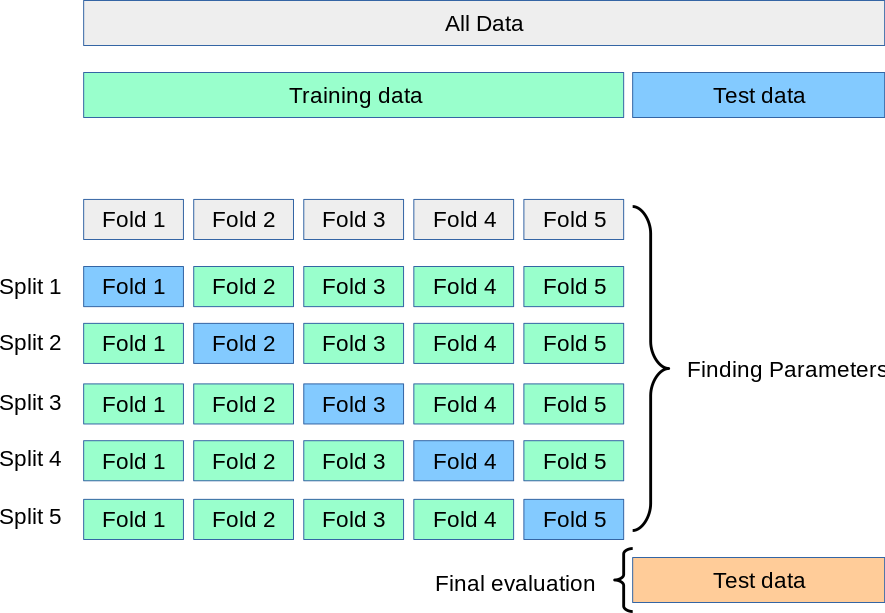

## Lasso regression

Ridge regression shrinks parameter estimates, but the estimates never reach exactly `0`. *Lasso* (which is an acronym for *least absolute shrinkage and selection operator*), on the other hand, works by trying to force small parameter estimates to be equal to `0`, effectively dropping them from the model. This can prevent overfitting, and it also works as an *embedded feature selection method*. Lasso is extremely handy when you are dealing with thousands or hundreds of thousands of predictors and need to optimize processor time, or when you want to arrive at a simpler solution that is easier to interpret.

The cost function to minimize for lasso is very similar to the cost function minimized for ridge:

$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2+\lambda\sum_{j=1}^p|\beta_j| $$

The difference is that rather than penalizing by the sum of *squared* coefficients as ridge does, lasso penalizes by the sum of the *absolute values* of the coefficients. This means the penalty doesn't increase as swiftly with coefficient size. Regularization based on the sum of the absolute weights is also called *L1 regularization*.

Why would penalizing with the sum of the absolute values of coefficients lead to a solution with zero estimates for some parameters, while penalizing with the sum of the squares of coefficients does not? It all comes down to derivatives. A partial derivative represents the sensitivity of one quantity to changes in another quantity. In the case of both OLS regression and ridge regression, the derivative used to find the optimal solution is the partial derivative of the cost function relative to the coefficients in $\beta$:

$$\frac{\partial}{\partial\beta}$$

Unfortunately, that won't work for lasso. Although you can calculate a derivative for most of the values of $x$ in lasso, there is no derivative where $x=0$. So, to fit a lasso regression, an algorithm called *coordinate descent* is used. You will not go into the details of this algorithm in this program, but you can find a detailed treatment of it in this [Wikipedia article](https://en.wikipedia.org/wiki/Coordinate_descent).

Now, fit a lasso regression model on the *House prices* data. As usual, use the same features that you used in the previous models.

In [8]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=10**20.5) 
lassoregr.fit(X_train, y_train)

# You are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.7531246860983718
-----Test set statistics-----
R-squared of the model on the test set is: 0.5534700128241108
Mean absolute error of the prediction is: 37169.49709729894
Mean squared error of the prediction is: 2997870196.331369
Root mean squared error of the prediction is: 54752.80994005119
Mean absolute percentage error of the prediction is: 22.397383107400525


The R-squared is `0.75` for the training set and `0.55` for the test set. The R-squared value in the test set is the highest among the models that you've used in this lesson. And the difference between the R-squared values of the training and test set is also the lowest. The performance statistics on the test set are the lowest too, which means that this lasso model performs better than both the ridge regression and linear regression models that you built previously.

### Tuning lasso's regularization parameter

The $\lambda$ for lasso can vary between zero (no penalty, acts like OLS) and infinity. If $\lambda$ is too large, all parameters will be set to `0`. As usual, the best way to determine the $\lambda$ parameter is cross-validation!

## Elastic net regression

As emphasized earlier in this lesson, both lasso and ridge regressions have their own merits and drawbacks. One popular method that combines both lasso's L1 regularization and ridge's L2 regularization is called *elastic net regression*. The loss function of elastic net regression is as follows: 

$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2+\lambda_1\sum_{j=1}^p|\beta_j| +\lambda_2\sum_{j=1}^p\beta_j^2$$

Notice that when $\lambda_1$ is equal to zero, this loss function turns into the loss function of ridge regression. And when $\lambda_2$ is equal to zero, it becomes the loss function of lasso regression. Hence, both lasso and ridge regression are special cases of elastic net regression. Moreover, when both $\lambda_1$ and $\lambda_2$ are equal to zero, elastic net becomes a linear regression model.

Now, try elastic net regression on the house prices model:

In [7]:
from sklearn.linear_model import ElasticNet

elasticregr = ElasticNet(alpha=10**21, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

# You are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.691896956935159
-----Test set statistics-----
R-squared of the model on the test set is: 0.411032945756721
Mean absolute error of the prediction is: 41599.58693019013
Mean squared error of the prediction is: 3954150514.512958
Root mean squared error of the prediction is: 62882.036500998904
Mean absolute percentage error of the prediction is: 23.625737604826178


According to the results, elastic net's training and test set performances are somewhere between lasso's and ridge's performances. 

### Tuning elastic net's regularization parameters

You may notice that in the elastic net regression, there are two hyperparameters to tune: $\lambda_1$ and $\lambda_2$. But scikit-learn's implementation uses different terminology: $alpha$ and $l1\_ratio$. Don't get confused by this. This is how it looks in scikit-learn's implementation:

$alpha = \lambda_1 + \lambda_2$ and $l1\_ratio = \frac{\lambda_1}{(\lambda_1 + \lambda_2)}$.

In other words, $\lambda_1 = alpha*l1\_ratio$ and $\lambda_2 = alpha*(1 - l1\_ratio)$. So, in effect, they are equivalent.

As emphasized before, when you're tuning hyperparameters for elastic net regression, the best approach is to apply cross-validation.